In [91]:
import pandas as pd
import numpy as np
import networkx as nx
from src.route_planning import *
from src.delay_model import route_confidence
from src.delay_model import process_istdaten_data
import copy
import random
from src.util import *
from src.transport_network import *
from sanity_test.graph_test import *
from sanity_test.path_test import *

## Test routes at different time of the day

We will define a function `test_route_at_different_times_and_days` to generate the confidence of the route at different time during day and analyze whether the confidence lowers at peak hours or not, meaning that delay gets
more important at peak hours.


We will test our model on the route : "Ecublens VD, EPFL" to "Pully, gare", according to Google Maps it takes beetween 20-30 minutes depending on the time of day.

In [92]:
istdaten_path = "data/sbb_real_stop_times.parquet"


In [93]:
grouped_istdaten = process_istdaten_data(istdaten_path)

In [94]:
sbb_network = TransportNetwork('data/sbb_timetable_stop_times.parquet', 'data/stop_to_stop.csv', 'data/stops.csv')
stops = sbb_network.stops
stop_to_stop = sbb_network.stop_to_stop
id_to_stop = stops.set_index('stop_id')['stop_name'].to_dict()
stop_to_id = stops.set_index('stop_name')['stop_id'].to_dict()

In [88]:
def test_route_at_different_times_and_days(network, stop_to_id, days_of_week, start_times, expected_times, departure, destination, grouped_istdaten):
    results = []

    for day_of_week in days_of_week:
        for start_time, expected_time in zip(start_times, expected_times):
           
                G = network.build_graph(start_time, expected_time)
                all_paths = yen_ksp(G, start_time, stop_to_id[departure], stop_to_id[destination], K=5)

                # Assuming you want to calculate confidence for the first path only
                if all_paths:
                    first_path = all_paths[0][0]  # This is the first path, which is a list of nodes
                    confidence = route_confidence(first_path, expected_time, grouped_istdaten)
                else:
                    confidence = None

                results.append({
                    'day_of_week': day_of_week,
                    'start_time': start_time,
                    'expected_time': expected_time,
                    'confidence': confidence
                })
           
    return pd.DataFrame(results)

days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


start_times = ['06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '21:00']
expected_times = ['06:45', '07:45', '08:45', '09:45', '10:45', '11:45', '12:45', '13:45', '14:45', '15:45', '16:45', '17:45', '18:45', '21:45']


departure = "Ecublens VD, EPFL"
destination = "Pully, gare"


results_df = test_route_at_different_times_and_days(sbb_network, stop_to_id, days_of_week, start_times, expected_times, departure, destination,grouped_istdaten)
print(results_df)

   day_of_week start_time expected_time  confidence
0       Monday      06:00         06:45    1.000000
1       Monday      07:00         07:45    1.000000
2       Monday      08:00         08:45    1.000000
3       Monday      09:00         09:45    1.000000
4       Monday      10:00         10:45    1.000000
..         ...        ...           ...         ...
93      Sunday      15:00         15:45    1.000000
94      Sunday      16:00         16:45    1.000000
95      Sunday      17:00         17:45    0.999994
96      Sunday      18:00         18:45    0.999982
97      Sunday      21:00         21:45    1.000000

[98 rows x 4 columns]


In [89]:
def analyze_confidence_statistics(results_df):
    # Group by start_time and expected_time to calculate statistics
    statistics_df = results_df.groupby(['start_time', 'expected_time']).agg({
        'confidence': ['mean', 'std', 'min', 'max', 'count']
    })

    # Renaming columns for clarity
    statistics_df.columns = ['Mean Confidence', 'Standard Deviation', 'Min Confidence', 'Max Confidence', 'Count']
    statistics_df = statistics_df.reset_index()

    return statistics_df

stats_df = analyze_confidence_statistics(results_df)
print(stats_df)



   start_time expected_time  Mean Confidence  Standard Deviation  \
0       06:00         06:45         1.000000                 0.0   
1       07:00         07:45         1.000000                 0.0   
2       08:00         08:45         1.000000                 0.0   
3       09:00         09:45         1.000000                 0.0   
4       10:00         10:45         1.000000                 0.0   
5       11:00         11:45         1.000000                 0.0   
6       12:00         12:45         1.000000                 0.0   
7       13:00         13:45         1.000000                 0.0   
8       14:00         14:45         0.998524                 0.0   
9       15:00         15:45         1.000000                 0.0   
10      16:00         16:45         1.000000                 0.0   
11      17:00         17:45         0.999994                 0.0   
12      18:00         18:45         0.999982                 0.0   
13      21:00         21:45         1.000000    

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

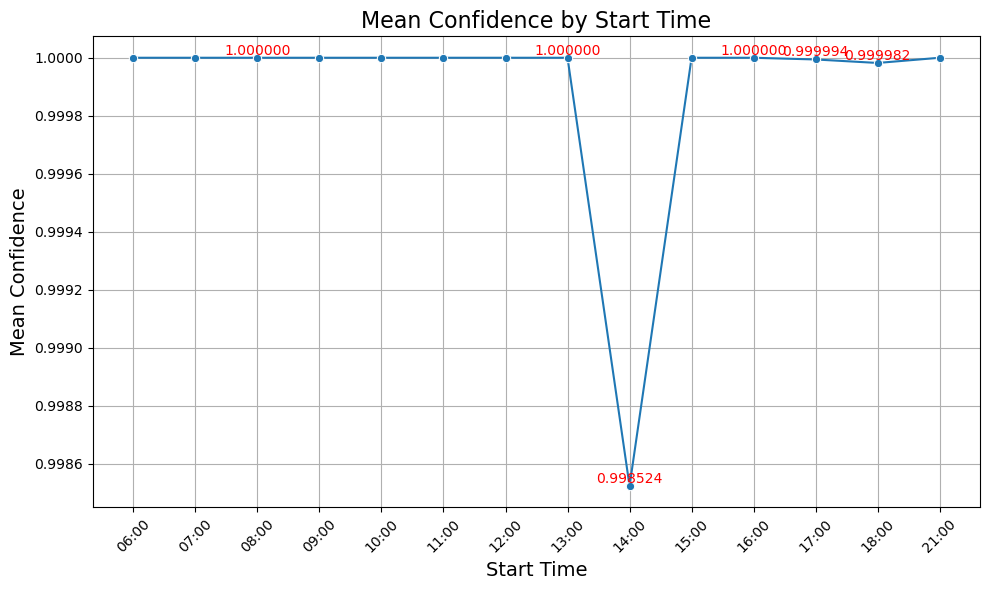

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=stats_df, x='start_time', y='Mean Confidence', marker='o')

# Adding titles and labels
plt.title('Mean Confidence by Start Time', fontsize=16)
plt.xlabel('Start Time', fontsize=14)
plt.ylabel('Mean Confidence', fontsize=14)
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.grid(True)  # Adding a grid for easier visualization of the confidence level

# Highlighting specific points where confidence is less than 1
for i, row in stats_df.iterrows():
    if row['Mean Confidence'] < 1:
        plt.text(row['start_time'], row['Mean Confidence'], f'{row["Mean Confidence"]:.6f}', 
                 color='red', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Summary of Route Confidence Analysis

<span style="font-size: 18px; font-weight: bold;">Observations:</span>

1. <span style="font-size: 16px;">**High Confidence Levels:**</span>
   - The mean confidence level remains at 1.0 for most of the start times, indicating that the model is highly confident about the reliability of the routes during these times.
   - The confidence level is slightly below 1.0 at two start times: 14:00 (0.998524) and 17:00 (0.999994), with the lowest being at 14:00.

2. <span style="font-size: 16px;">**Variation at Specific Times:**</span>
   - At 14:00, there is a noticeable dip in the mean confidence level (0.998524). This suggests that the model predicts a slightly lower reliability for routes starting at this time.
   - At 17:00 and 18:00, the confidence levels are also marginally lower than 1.0, indicating minor uncertainty during these periods.

<span style="font-size: 18px; font-weight: bold;">Analysis:</span>
- <span style="font-size: 16px;">**Peak Hours Impact:**</span> The slight dips in confidence around 14:00 and 17:00 could be associated with increased variability in travel times during peak hours or times when there is more traffic and congestion. This aligns with typical urban patterns where travel reliability can fluctuate during busy hours.
- <span style="font-size: 16px;">**Overall Reliability:**</span> The consistently high confidence levels (mostly 1.0) suggest that the routes are generally very reliable, with little variation in travel times, except for the minor deviations at specific times.


<span style="font-size: 18px; font-weight: bold;">Conclusion:</span>
The plot indicates that the route confidence model performs well overall, maintaining high confidence throughout most of the day. The minor dips at 14:00 and 17:00 are consistent with rush hour times. 
